### Imports

In [66]:
import sys
import os
script_dir = os.getcwd()
root_dir = os.path.join(os.path.dirname(os.path.abspath(script_dir)))
sys.path.append(os.path.join(os.path.dirname(os.path.abspath(script_dir))))

import json
import pandas as pd
import numpy as np
from utils.io import load_object, save_object
from utils.evaluation import calc_eval_metrics
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc


### Manuscript Figures

#### Figure 2A. Accuracy of LLM across various prompt strategies

In [67]:
moalmanac_data=pd.read_csv(os.path.join(root_dir, 'data/moa_fda_queries_answers.csv'), index_col=0)
synthetic_prompt_groundtruth_dict=load_object(os.path.join(root_dir, 'data/synthetic_prompt_groundtruth_dict.pkl'))

In [68]:
llm_mistnemo_res_dict_0 = load_object(filename=os.path.join(root_dir, 'output/LLM_res_mistnemo/stra0n1temp0.0_res_dict.pkl'))
llm_mistnemo_res_dict_1 = load_object(filename=os.path.join(root_dir, 'output/LLM_res_mistnemo/stra1n1temp0.0_res_dict.pkl'))
llm_mistnemo_res_dict_2 = load_object(filename=os.path.join(root_dir, 'output/LLM_res_mistnemo/stra2n1temp0.0_res_dict.pkl'))
llm_mistnemo_res_dict_3 = load_object(filename=os.path.join(root_dir, 'output/LLM_res_mistnemo/stra3n1temp0.0_res_dict.pkl'))

In [5]:
plot_res = pd.DataFrame(
    {
    'Basic_prompt' : [calc_eval_metrics(llm_mistnemo_res_dict_0['full output'][0], moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)['avg_partial_match_acc']],
    'Basic_prompt_condition' : [calc_eval_metrics(llm_mistnemo_res_dict_1['full output'][0], moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)['avg_partial_match_acc']],
    'Basic_prompt_system' : [calc_eval_metrics(llm_mistnemo_res_dict_2['full output'][0], moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)['avg_partial_match_acc']],
    'Basic_prompt_combined' : [calc_eval_metrics(llm_mistnemo_res_dict_3['full output'][0], moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)['avg_partial_match_acc']]
    }
    )
    
plot_res = plot_res.iloc[0,:].to_frame()
plot_res[1] = plot_res[0]*100
print(plot_res)

                               0          1
Basic_prompt            0.692308  69.230769
Basic_prompt_condition  0.534188  53.418803
Basic_prompt_system     0.645299  64.529915
Basic_prompt_combined   0.512821  51.282051


In [6]:
plot_res[1].rename(index={
    'Basic_prompt':'(1) Basic prompt',
    'Basic_prompt_condition':'(2) Basic prompt + condition',
    'Basic_prompt_system':'(3) Basic prompt + system role',
    'Basic_prompt_combined':'(4) Basic prompt + (2) + (3)'
                          }, inplace=True)


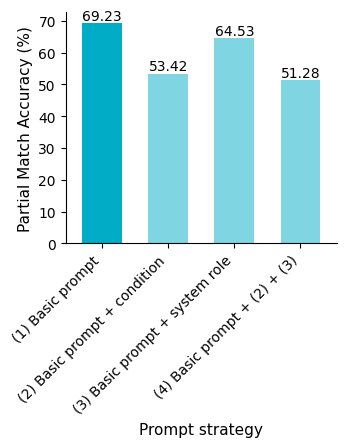

In [ ]:
# set figure size
plt.rcParams["figure.figsize"] = [3.5, 3]

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# create bar plot
ax=plot_res[1].plot(kind='bar', color=cols[3], width=0.6, legend=False)

# add text
for i, v in enumerate(plot_res[1]):
    ax.text(x=i, y=v+0.05, s=f'{v:.2f}', ha='center', va='bottom', fontsize=10)

# x, y label and ticks
ax.set_xlabel('Prompt strategy', fontsize=11)
ax.set_ylabel('Partial Match Accuracy (%)', fontsize=11)
plt.xticks(rotation=45, ha='right')

# borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# highlight first bar
ax.patches[0].set_facecolor(cols[3])

# set alpha for the rest of the bars
for i, patch in enumerate(ax.patches):
    if i != 0:  
        patch.set_alpha(0.5) 

# save
save = True
if save == True:
    plt.savefig('./figures/Figure2_accuracyLLMprompt.jpeg', dpi=500, bbox_inches='tight')

plt.show()

#### Figure 2B. Accuracy of LLMs of various sizes across prompt strategies

##### Statistical test on basic vs. combination prompts

In [ ]:
# Load McNemar package
from statsmodels.stats.contingency_tables import mcnemar

# Function to create a contingency matrix for McNemar's test
def create_mcnemar_table(y_pred_A, y_pred_B):
    
    # Convert to numpy arrays for easy element-wise comparison
    y_pred_A = np.array(y_pred_A)
    y_pred_B = np.array(y_pred_B)

    # Compute contingency table values
    a = np.sum((y_pred_A == True) & (y_pred_B == True)) # Both correct
    b = np.sum((y_pred_A == True) & (y_pred_B == False)) # A correct, B incorrect
    c = np.sum((y_pred_A == False) & (y_pred_B == True)) # A incorrect, B correct
    d = np.sum((y_pred_A == False) & (y_pred_B == False)) # Both incorrect

    # Create contingency table
    table = np.array([[a, b], [c, d]])

    return({
        'table':table,
        'bc':b+c
        })

In [9]:
# Load LLM-only outputs and evaluate
models = ['mist7B', 'mist8B', 'mistnemo', 'mistlarge', 'gptmini', 'gpt']
strategies = [0, 3]

llm_output_dicts = {}
llm_eval_res = {}
partial_acc_dicts = {}

for model in models:
    model_eval = {}
    for strategy in strategies:
        output_key = f"llm_{model.lower()}_res_dict_{strategy}"
        eval_key = f"llm_{model.lower()}_eval_res_{strategy}"
        
        # Load LLM outputs
        path = os.path.join(root_dir, f'output/LLM_res_{model}/stra{strategy}n1temp0.0_res_dict.pkl')
        llm_output_dicts[output_key] = load_object(filename=path)
        
        # Evaluate LLM outputs
        eval_result = calc_eval_metrics(llm_output_dicts[output_key]['full output'][0], moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)
        llm_eval_res[eval_key] = eval_result
        
        # Save each model's results
        model_eval[strategy] = {'partial_match_acc':eval_result['partial_match_acc'], 'avg_partial_match_acc':eval_result['avg_partial_match_acc']}
        
    partial_acc_dicts[f"{model}_partial_acc_dict"] = model_eval
    

In [10]:
# Create contingency table for mcnemar's test
mcnemar_tables = {}
for model in models:
    mcnemar_tables[f'{model}_partial_table'] = create_mcnemar_table(
        partial_acc_dicts[f'{model}_partial_acc_dict'][3]['partial_match_acc'], 
        partial_acc_dicts[f'{model}_partial_acc_dict'][0]['partial_match_acc']
    )
    

In [11]:
# Perform McNemar's test (use exact=True if b+c < 25)
def conduct_mcnemar_test(table):
    if table['bc'] < 25:
        result = mcnemar(table['table'], exact=True, correction=True) 
    else:
        result = mcnemar(table['table'], exact=False, correction=True)
        
    return(result)

# Print results
def print_mcnemar_res(mcnemar_result, alpha):
    significance = mcnemar_result.pvalue < alpha
    print(f"Significant: {significance}; Test Statistic: {mcnemar_result.statistic}; P-value: {mcnemar_result.pvalue}")    


In [12]:
# Run McNemar and get accuracies
model_labels = dict(zip(models, ['mist_7B', 'mist_8B', 'mistnemo_12B', 'mistlarge_123B', 'gpt4omini', 'gpt4o']))

mcnemar_result = {}
accuracy = {}
p_values = {}

for model, label in model_labels.items():
    # Run McNemar's test
    mcnemar_result[f'{model}_mcnemar_res'] = conduct_mcnemar_test(mcnemar_tables[f'{model}_partial_table'])
    print_mcnemar_res(mcnemar_result[f'{model}_mcnemar_res'], alpha=0.05)

    # Get p-values
    p_values[label] = mcnemar_result[f'{model}_mcnemar_res'].pvalue
    
    # Get accuracies
    accuracy[label] = [
        partial_acc_dicts[f'{model}_partial_acc_dict'][0]['avg_partial_match_acc'], 
        partial_acc_dicts[f'{model}_partial_acc_dict'][3]['avg_partial_match_acc']
    ]

Significant: False; Test Statistic: 2.938775510204082; P-value: 0.08647626549366548
Significant: False; Test Statistic: 2.56; P-value: 0.10959858339911568
Significant: True; Test Statistic: 38.20454545454545; P-value: 6.370385309896191e-10
Significant: False; Test Statistic: 5.0; P-value: 0.30175781249999994
Significant: False; Test Statistic: 5.0; P-value: 0.09625244140625
Significant: False; Test Statistic: 3.0; P-value: 0.057373046875


##### Plot bar graph

In [13]:
all_models_acc=pd.DataFrame(accuracy)
all_models_acc.rename(index={
    0:'(1) Basic prompt',
    1:'(2) Basic prompt + (2) + (3)'
    }, inplace=True
)

all_models_acc=all_models_acc*100
all_models_acc=all_models_acc.transpose()
all_models_acc

,(1) Basic prompt,(2) Basic prompt + (2) + (3)
mist_7B,32.051282,37.606838
mist_8B,44.444444,48.290598
mistnemo_12B,69.230769,51.282051
mistlarge_123B,67.094017,64.957265
gpt4omini,70.512821,67.094017
gpt4o,75.641026,72.222222


In [14]:
def pval_to_stars(p):
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return ''

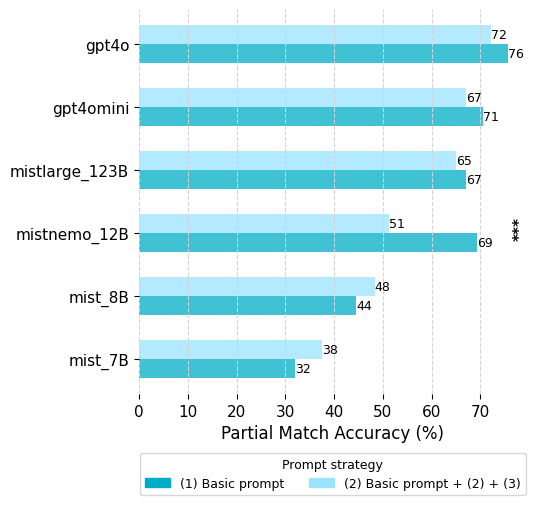

In [ ]:
plot_res=all_models_acc

# set figure size
plt.rcParams["figure.figsize"] = [5, 5]

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# create a mapping of rownames to colors
row_colors = dict(zip(plot_res.columns, [cols[3],cols[25]]))

# create bar plot
ax=plot_res.plot(kind='barh', color=row_colors, width=0.6, legend=False)

# add text
for bar in ax.patches:
    x = bar.get_width() # bar length (horizontal position)
    y = bar.get_y() + bar.get_height()/2 # center the bar (vertical position)
    ax.text(x+0.02, y, f'{x:.0f}', ha='left', va='center', fontsize=9)
    
# add p-value significance
yticks = np.arange(len(plot_res.index))  
bar_height = ax.patches[0].get_height()
n_bars = plot_res.shape[1] # bars per group (i.e., columns in plot_res)
bar_offsets = np.linspace(-bar_height/2, bar_height/2, n_bars, endpoint=False) # offsets per bar within group

for i, (label, pval) in enumerate(p_values.items()):
    if label not in plot_res.index:
        continue
    row_idx = plot_res.index.get_loc(label)

    # Get the bars for this group
    bar_group = ax.patches[row_idx * n_bars : (row_idx + 1) * n_bars]
    if len(bar_group) < 2:
        continue

    bar1, bar2 = bar_group
    y_pos = yticks[row_idx] + np.mean(bar_offsets[:2]) + bar_height / 2

    # Place to the right of the longer bar
    x_pos = max(bar1.get_width(), bar2.get_width()) + 1.0

    # Convert p-value to stars
    sig = pval_to_stars(pval)
    if sig:
        ax.text(x_pos, y_pos, sig,
                ha='left', va='center',
                fontsize=11, fontweight='bold', rotation=90)

    
# x, y label and ticks
ax.set_xlabel('Partial Match Accuracy (%)', fontsize=12)
ax.set_ylabel('')
ax.tick_params(labelsize=11)
for spine in ax.spines.values():
    spine.set_visible(False)

# set alpha for the rest of the bars
for i, patch in enumerate(ax.patches):
    patch.set_alpha(0.75)

# Create a custom legend
handles = [plt.Rectangle((0,0),1,1, color=row_colors[name]) for name in plot_res.columns]
legend = ax.legend(handles, plot_res.columns, 
          title="Prompt strategy", 
          bbox_to_anchor=(0.5, -0.12), ncol=2,
          borderaxespad=1,
          loc='upper center',
          fontsize=9,
          title_fontsize=9
          )
legend.get_frame().set_facecolor('white')

# set background and grid color
ax.set_facecolor('white')
ax.grid(axis='x', linestyle='--', color='lightgray', linewidth=0.8)

# save
save = True
if save == True:
    plt.savefig('./figures/Figure2_accuracyPromptLLMbar.jpeg', dpi=500, bbox_inches='tight')
plt.show()

#### Figure 2C-D. Distribution of the length of unstructured FDA-approval 'Indication and Usage' section and structured FDA-approval indications

In [16]:
# function to calculate IQR (interquartile range)
def calc_iqr(chunk_size_list):
    q1 = np.percentile(chunk_size_list, 25)
    q3 = np.percentile(chunk_size_list, 75)
    iqr = f'{q1}-{q3}'
    return(iqr)

Unstructured dataset

In [17]:
# load unstructured context derived from FDA drug label indication and usage sections (deduplicated, full)
with open(os.path.join(root_dir,"data/unstructured_context_chunks.json"), "r") as f:
    unstructured_dataset = json.load(f)
    
len(unstructured_dataset)

56

# chunks: 56
Min: 241
Max: 9883
Mean: 1003.5
Median: 734.5
IQR: 552.0-976.75


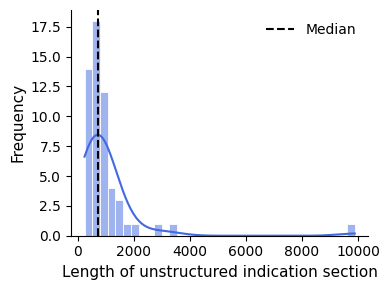

In [ ]:
# get chunk size
unstruc_chunk_size=[len(chunk) for chunk in unstructured_dataset]
print("# chunks: "+str(len(unstruc_chunk_size)))
print("Min: "+str(np.min(unstruc_chunk_size)))
print("Max: "+str(np.max(unstruc_chunk_size)))
print("Mean: "+str(np.mean(unstruc_chunk_size)))
print("Median: "+str(np.median(unstruc_chunk_size)))
print("IQR: "+str(calc_iqr(unstruc_chunk_size)))

# set figure size and subplot
plt.rcParams["figure.figsize"] = [3.5, 3]
fig, ax = plt.subplots(tight_layout=True, figsize=(4,3))

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# histogram with KDE
n_bins=35
sns.histplot(unstruc_chunk_size, bins=n_bins, kde=True, stat='count',
             color='royalblue', alpha=0.5, edgecolor='white', ax=ax)

# median line
plt.axvline(np.median(unstruc_chunk_size), color='black', 
            linestyle='--', linewidth=1.5, label='Median', alpha=1)

# x, y labels and ticks
ax.set_xlabel('Length of unstructured indication section', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11) # raw counts

# remove top and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# add the legend
# plt.legend()
ax.legend(ncol=1, frameon=False)

# save plot
save = True
if save == True:
    plt.savefig('./figures/Figure2_unstructuredlength_dist.jpeg', dpi=500, bbox_inches='tight')

plt.show()


Structured dataset

In [19]:
# load structured context derived from moalmanac data fields
with open(os.path.join(root_dir,"data/structured_context_chunks.json"), "r") as f:
    structured_dataset = json.load(f)

len(structured_dataset)

234

# chunks: 234
Min: 489
Max: 1178
Mean: 761.8760683760684
Median: 733.5
IQR: 649.25-827.0


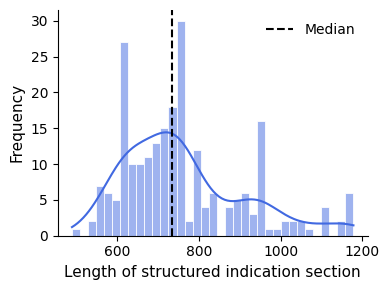

In [ ]:
# get chunk size
struc_chunk_size=[len(chunk) for chunk in structured_dataset]
print("# chunks: "+str(len(struc_chunk_size)))
print("Min: "+str(np.min(struc_chunk_size)))
print("Max: "+str(np.max(struc_chunk_size)))
print("Mean: "+str(np.mean(struc_chunk_size)))
print("Median: "+str(np.median(struc_chunk_size)))
print("IQR: "+str(calc_iqr(struc_chunk_size)))

# set figure size and subplot
plt.rcParams["figure.figsize"] = [3.5, 3]
fig, ax = plt.subplots(tight_layout=True, figsize=(4,3))

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# histogram with KDE
n_bins=35
sns.histplot(struc_chunk_size, bins=n_bins, kde=True, stat='count',
             color='royalblue', alpha=0.5, edgecolor='white', ax=ax)

# median line
plt.axvline(np.median(struc_chunk_size), color='black', 
            linestyle='--', linewidth=1.5, label='Median', alpha=1)

# x, y labels and ticks
ax.set_xlabel('Length of structured indication section', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11) # raw counts

# remove top and right border
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# add legend
ax.legend(ncol=1, frameon=False)

# save plot
save = True
if save == True:
    plt.savefig('./figures/Figure2_structuredlength_dist.jpeg', dpi=500, bbox_inches='tight')

plt.show()


#### Figure 3A. Impact of RAG integration on LLM performance with unstructured and structured database

In [21]:
# Load RAG-LLM results
rag_struc_res_dict_0 = load_object(filename=os.path.join(root_dir, 'output/RAG_res_mistnemo/structured/RAGstra0n5temp0.0_res_dict.pkl'))
rag_unstruc_res_dict_0 = load_object(filename=os.path.join(root_dir, 'output/RAG_res_mistnemo/unstructured/RAGstra0n5temp0.0_res_dict.pkl'))

# Calculate evaluation metrics for the RAG-LLM output from the first iteration
unstruc_results = calc_eval_metrics(rag_unstruc_res_dict_0['full output'][0], moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)
struc_results = calc_eval_metrics(rag_struc_res_dict_0['full output'][0], moalmanac_data['prompt'], synthetic_prompt_groundtruth_dict)
llm_results = llm_eval_res['llm_mistnemo_eval_res_0']

print(f"Unstructured: {unstruc_results['avg_exact_match_acc']}, {unstruc_results['avg_partial_match_acc']}")
print(f"Structured: {struc_results['avg_exact_match_acc']}, {struc_results['avg_partial_match_acc']}")
print(f"LLM-only: {llm_results['avg_exact_match_acc']}, {llm_results['avg_partial_match_acc']}")

Unstructured: 0.7307692307692307, 0.8504273504273504
Structured: 0.905982905982906, 0.9871794871794872
LLM-only: 0.5384615384615384, 0.6923076923076923


##### Run McNemar's test for statistical significance

LLM-only vs. RAG-LLM unstructured

In [22]:
# Create contingency table
exact_table=create_mcnemar_table(llm_results['exact_match_acc'], unstruc_results['exact_match_acc'])
partial_table=create_mcnemar_table(llm_results['partial_match_acc'], unstruc_results['partial_match_acc'])

# Perform McNemar's test (exact=True if b+c < 25)
exact_result = conduct_mcnemar_test(exact_table) 
partial_result = conduct_mcnemar_test(partial_table) 

# Print results
print(f"Exact match test Statistic: {exact_result.statistic}")
print(f"Exact match p-value: {exact_result.pvalue}")
print(f"Partial match test Statistic: {partial_result.statistic}")
print(f"Partial match p-value: {partial_result.pvalue}")

# Print interpretations
alpha = 0.05
print(f"Significant difference in exact match acc: {exact_result.pvalue < alpha}")
print(f"Significant difference in partial match acc: {partial_result.pvalue < alpha}")


Exact match test Statistic: 23.901234567901234
Exact match p-value: 1.0140670844453472e-06
Partial match test Statistic: 18.253521126760564
Partial match p-value: 1.9336816600800142e-05
Significant difference in exact match acc: True
Significant difference in partial match acc: True


RAG-LLM unstructured vs. RAG-LLM structured

In [23]:
# Create contingency table
exact_table=create_mcnemar_table(unstruc_results['exact_match_acc'], struc_results['exact_match_acc'])
partial_table=create_mcnemar_table(unstruc_results['partial_match_acc'], struc_results['partial_match_acc'])

# Perform McNemar's test
exact_result = conduct_mcnemar_test(exact_table) 
partial_result = conduct_mcnemar_test(partial_table) 

# Print results
print(f"Exact match test Statistic: {exact_result.statistic}")
print(f"Exact match p-value: {exact_result.pvalue}")
print(f"Partial match test Statistic: {partial_result.statistic}")
print(f"Partial match p-value: {partial_result.pvalue}")

# Print interpretations
alpha = 0.05
print(f"Significant difference in exact match acc: {exact_result.pvalue < alpha}")
print(f"Significant difference in partial match acc: {partial_result.pvalue < alpha}")


Exact match test Statistic: 25.396825396825395
Exact match p-value: 4.6668548096211404e-07
Partial match test Statistic: 28.264705882352942
Partial match p-value: 1.0580771204088795e-07
Significant difference in exact match acc: True
Significant difference in partial match acc: True


##### Plot bar graph

In [24]:
plot_res=pd.DataFrame({
    'Unstructured RAG-LLM': [unstruc_results['avg_partial_match_acc'], unstruc_results['avg_exact_match_acc']],
    'Structured RAG-LLM': [struc_results['avg_partial_match_acc'], struc_results['avg_exact_match_acc']],
}, index=['Partial match accuracy','Exact match accuracy'])
plot_res=plot_res*100

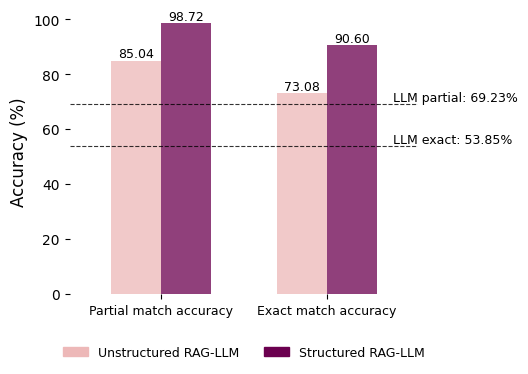

In [ ]:
# set figure size
plt.rcParams["figure.figsize"] = [4.5, 3.7]

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# create a mapping of rownames to colors
row_colors = dict(zip(plot_res.columns, [cols[23],cols[6]]))

# create bar plot
ax=plot_res.plot(kind='bar', color=[row_colors[name] for name in plot_res.columns], width=0.6, legend=False)

# add text
for bar in ax.patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax.text(x, y+0.02, f'{y:.2f}', ha='center', va='bottom', fontsize=9)
    
# x, y labels, ticks, grid
ax.set_xlabel('')
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.tick_params(axis='x', labelsize=9, rotation=0)
ax.tick_params(axis='y', labelsize=10)
ax.set_facecolor(color='white')

# add LLM accuracy horizontal line and text
ax.axhline(y=llm_results['avg_exact_match_acc']*100, color='black', linestyle='--', linewidth=0.8, alpha=0.8)
ax.axhline(y=llm_results['avg_partial_match_acc']*100, color='black', linestyle='--', linewidth=0.8, alpha=0.8)
ax.text(
    x=len(plot_res.columns) - 0.6,  
    y=llm_results['avg_exact_match_acc']*100 + 1,  
    s=f"LLM exact: {llm_results['avg_exact_match_acc']*100:.2f}%",
    color='black', fontsize=9
    )    
ax.text(
    x=len(plot_res.columns) - 0.6,  
    y=llm_results['avg_partial_match_acc']*100 + 1,  
    s=f"LLM partial: {llm_results['avg_partial_match_acc']*100:.2f}%",
    color='black', fontsize=9
    )    

# remove border
for spine in ax.spines.values():
    spine.set_visible(False)
    
# set alpha for the rest of the bars
for i, patch in enumerate(ax.patches):
    patch.set_alpha(0.75)

# create a custom legend
handles = [plt.Rectangle((0,0),1,1, color=row_colors[name]) for name in plot_res.columns]
legend = ax.legend(handles, plot_res.columns, 
          title=False, 
          bbox_to_anchor=(0.5, -0.12), ncol=2,
          frameon=False,
          borderaxespad=1,
          loc='upper center',
          fontsize=9,
          title_fontsize=9
          ) 
legend.get_frame().set_facecolor('white')

# save
save = True
if save == True:
    plt.savefig('./figures/Figure3_accuracyRAGLLMbar.jpeg', dpi=500, bbox_inches='tight')

plt.show()

#### Figure 3B. Impact on other evaluation metrics: precision, recall, f1, specificity

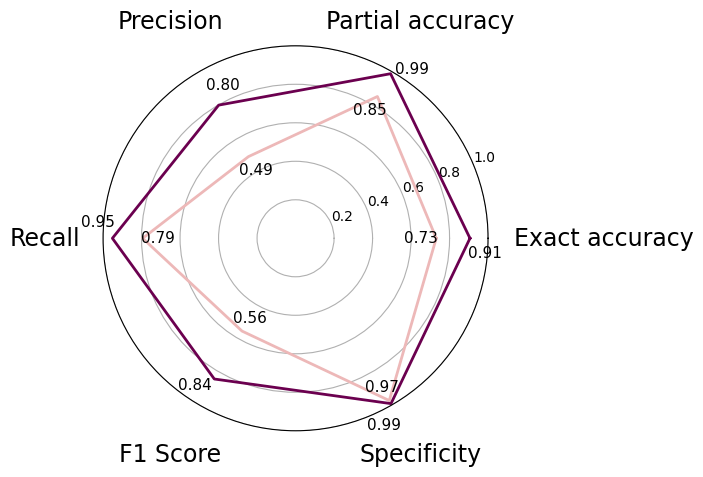

In [ ]:
from math import pi
import matplotlib.pyplot as plt

# Color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# Metrics
metrics = ['Exact accuracy', 'Partial accuracy', 'Precision', 'Recall', 'F1 Score', 'Specificity']

# Values for unstructured model
values_unstruc = [
    unstruc_results['avg_exact_match_acc'],
    unstruc_results['avg_partial_match_acc'],
    unstruc_results['avg_precision'], 
    unstruc_results['avg_recall'],
    unstruc_results['avg_f1'],
    unstruc_results['avg_specificity']
    ]
values_unstruc += values_unstruc[:1] # close the loop

# Values for structured model
values_struc = [
    struc_results['avg_exact_match_acc'],
    struc_results['avg_partial_match_acc'],
    struc_results['avg_precision'], 
    struc_results['avg_recall'],
    struc_results['avg_f1'],
    struc_results['avg_specificity']
    ]
values_struc += values_struc[:1]

# Radar chart setup
angles = [n / float(len(metrics)) * 2 * pi for n in range(len(metrics))]
angles += angles[:1]

# Set up the plot
plt.figure(figsize=(5, 5))
ax = plt.subplot(111, polar=True)

# Plot the models
ax.plot(angles, values_unstruc, color=cols[23], linewidth=2, linestyle='solid',
        label='RAG with unstructured database')
ax.plot(angles, values_struc, color=cols[6], linewidth=2, linestyle='solid', 
        label='RAG with structured database')

# Annotate each metric value
for i in range(len(metrics)):
    ax.text(angles[i], values_unstruc[i] - 0.08, 
            f"{values_unstruc[i]:.2f}",
            color='black', fontsize=11, ha='center', va='center')
    ax.text(angles[i] - 0.08, values_struc[i] + 0.08, 
            f"{values_struc[i]:.2f}",
            color='black', fontsize=11, ha='center', va='center')

# Labels and ticks
ax.set_ylim(0, 1.0)
ax.tick_params(axis='y', labelsize=10)
ax.set_xticks([])
for i, metric in enumerate(metrics): # Manually set the position of the labels outside the chart
    angle = angles[i]  
    if angle == 0:  
        ax.text(angle, 1.6, metric, horizontalalignment='center', verticalalignment='center', fontsize=17)       
    else:
        ax.text(angle, 1.3, metric, horizontalalignment='center', verticalalignment='center', fontsize=17)       

# Save plot
save = True
if save == True:
    plt.savefig('./figures/Figure3_ragllmPerformance_radar.jpeg', dpi=600, bbox_inches='tight')

plt.show()

In [ ]:
# Calculate percent increase of evaluation metrics
def perc_increase(old, new):
    if old == 0:
        if new == 0:
            return 0  
        return None  
    return ((new - old) / old) * 100

perc_increase_ls=[]
for i in range(len(values_unstruc)):
    perc_increase_ls.append(perc_increase(new=values_struc[i], old=values_unstruc[i]))

print(dict(zip(['exact_match_acc', 'partial_match_acc','avg_precision','avg_recall','avg_f1','avg_specificity'],perc_increase_ls)))
print(f'Precision: {values_unstruc[2]*100:.1f} to {values_struc[2]*100:.1f}')
print(f'F1-score: {values_unstruc[4]*100:.1f} to {values_struc[4]*100:.1f}')

{'exact_match_acc': 23.97660818713451, 'partial_match_acc': 16.08040201005026, 'avg_precision': 63.10070666928588, 'avg_recall': 19.820627802690677, 'avg_f1': 51.658880652544056, 'avg_specificity': 1.8842620713047666}
Precision: 49.0 to 79.9
F1-score: 55.7 to 84.4


#### Figure 3C. Accuracy of RAG-LLM across therapies, diseases and genomic alterations

In [41]:
# Create df for plotting
plot_df = moalmanac_data
plot_df['RAGLLM_struc_res'] = struc_results['exact_match_acc']
plot_df['RAGLLM_unstruc_res'] = unstruc_results['exact_match_acc']
plot_df['oncotree_code'] = plot_df['oncotree_code'].fillna('Any solid tumor')

Accuracy across cancer types

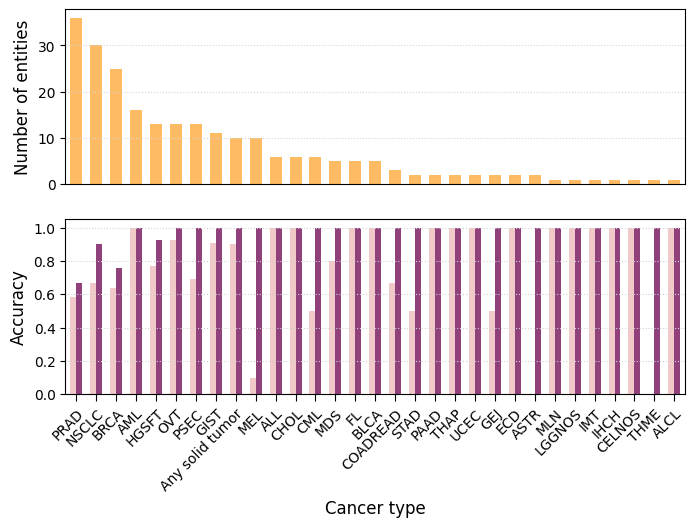

In [43]:
# set figure subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,5), gridspec_kw=dict(height_ratios=[1, 1]))

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# create accuracy dataframe 
df_all = pd.DataFrame()
for col in ['RAGLLM_unstruc_res', 'RAGLLM_struc_res']:
    df = pd.crosstab(plot_df['oncotree_code'], plot_df[col])
    df['accuracy'] = df[True] / (df[True] + df[False])
    df_all = pd.concat([df_all, df.rename(columns = {'accuracy':col})[col]], axis = 1)

# add counts (number of relationships)
group_cnt_df = pd.DataFrame.from_dict(Counter(plot_df['oncotree_code']), orient="index", columns=["Number of relationships"])
df_all=df_all.merge(group_cnt_df, left_index=True, right_index=True)

# sort by number of relationships (descending) 
df_all = df_all.sort_values(by="Number of relationships", ascending=False)

# create a mapping of names to colors
struc_unstruc_colors = dict(zip(df_all.columns[0:2], [cols[23],cols[6]]))
num_rel_color = cols[7]

# create bar plot
df_all[['RAGLLM_unstruc_res', 'RAGLLM_struc_res']].plot(kind='bar', color=struc_unstruc_colors, 
                                                        width=0.6, legend=False, ax=axes[1])
df_all['Number of relationships'].plot(kind='bar', color=num_rel_color, width=0.6, legend=False, ax=axes[0])
    
# x, y label and ticks
axes[0].set_ylabel('Number of entities', fontsize=12)
axes[0].set_xticks([])
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_xlabel('Cancer type', fontsize=12)
axes[1].tick_params(axis='x', labelrotation=45, size=5)
for label in axes[1].get_xticklabels():
    label.set_ha('right') 
    label.set_rotation_mode('anchor')

# set alpha for the rest of the bars
for i, patch in enumerate(axes[0].patches):
    patch.set_alpha(0.75)

for i, patch in enumerate(axes[1].patches):
    patch.set_alpha(0.75)

# change background and grid color
for ax in axes:
    # change background color
    ax.set_facecolor('white')
    # change grid color
    ax.grid(visible=True, axis='y', color='lightgray', linestyle='dotted')  

# Save plot
save = True
if save == True:
    plt.savefig('./figures/Figure3_cancerAcc_heatmap.jpeg', dpi=600, bbox_inches='tight')
plt.show()

In [44]:
# calculate percentage increase
df_all['perc_increase'] = df_all.apply(lambda row: perc_increase(old=row['RAGLLM_unstruc_res'], 
                                                                 new=row['RAGLLM_struc_res']), 
                                       axis=1)

df_all_perc=df_all.sort_values(by="perc_increase", ascending=False)

# top cancer types with percentage increase >= 30 and number of relationships >= 5
df_all_perc.loc[(df_all_perc['perc_increase'] >= 30) & (df_all_perc['Number of relationships'] >= 5), :]\
    .merge(plot_df[['oncotree_term','oncotree_code']], 
           left_index=True, right_on='oncotree_code', how='inner')\
               .drop_duplicates()

,RAGLLM_unstruc_res,RAGLLM_struc_res,Number of relationships,perc_increase,oncotree_term,oncotree_code
30,0.100000,1.0,10,900.000000,Melanoma,MEL
0,0.500000,1.0,6,100.000000,Chronic Myelogenous Leukemia,CML
44,0.692308,1.0,13,44.444444,Peritoneal Serous Carcinoma,PSEC
6,0.666667,0.9,30,35.000000,Non-Small Cell Lung Cancer,NSCLC


Accuracy across therapy types

In [45]:
# clean therapy strategy names
plot_df['therapy_strategy_2']=plot_df['therapy_strategy'].replace(r'inhibition|targets|signaling','', regex=True).str.replace(r'\s+', ' ', regex=True).replace(r'chemotherapy|Chemotherapy','chemo', regex=True).str.strip()

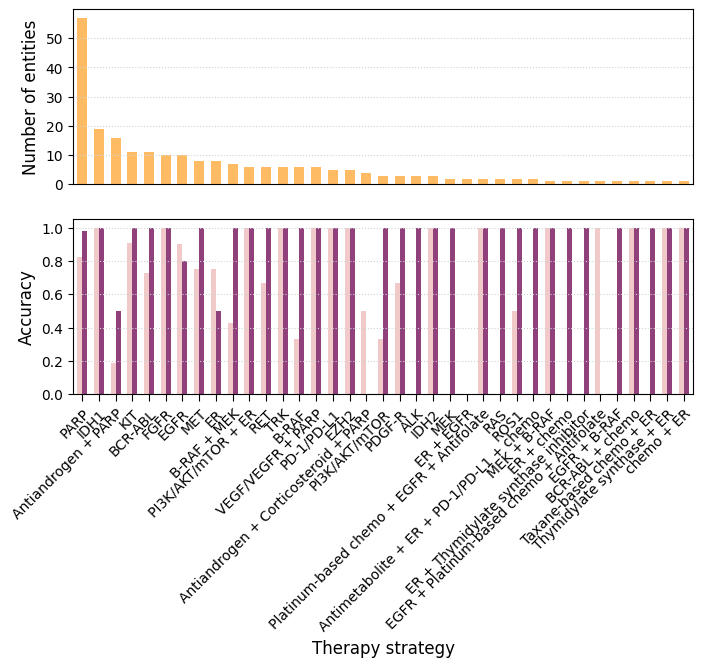

In [46]:
# set figure subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8,5), gridspec_kw=dict(height_ratios=[1, 1]))

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# create accuracy dataframe 
df_all = pd.DataFrame()
for col in ['RAGLLM_unstruc_res', 'RAGLLM_struc_res']:
    df = pd.crosstab(plot_df['therapy_strategy_2'], plot_df[col])
    df['accuracy'] = df[True] / (df[True] + df[False])
    df_all = pd.concat([df_all, df.rename(columns = {'accuracy':col})[col]], axis = 1)

# add counts (number of relationships)
group_cnt_df = pd.DataFrame.from_dict(Counter(plot_df['therapy_strategy_2']), orient="index", columns=["Number of relationships"])
df_all = df_all.merge(group_cnt_df, left_index=True, right_index=True)

# sort by number of relationships (descending) 
df_all = df_all.sort_values(by="Number of relationships", ascending=False)

# create a mapping of names to colors
struc_unstruc_colors = dict(zip(df_all.columns[0:2], [cols[23],cols[6]]))
num_rel_color = cols[7]

# create bar plot
df_all[['RAGLLM_unstruc_res', 'RAGLLM_struc_res']].plot(kind='bar', color=struc_unstruc_colors, width=0.6, legend=False, ax=axes[1])
df_all['Number of relationships'].plot(kind='bar', color=num_rel_color, width=0.6, legend=False, ax=axes[0])
    
# x, y label and ticks
axes[0].set_ylabel('Number of entities', fontsize=12)
axes[0].set_xticks([])
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_xlabel('Therapy strategy', fontsize=12)
axes[1].tick_params(axis='x', labelrotation=45, size=5)
for label in axes[1].get_xticklabels():
    label.set_ha('right') 
    label.set_rotation_mode('anchor') 

# set alpha for the rest of the bars
for i, patch in enumerate(axes[0].patches):
    patch.set_alpha(0.75)

for i, patch in enumerate(axes[1].patches):
    patch.set_alpha(0.75)

# change background and grid color
for ax in axes:
    # change background color
    ax.set_facecolor('white')
    # change grid color
    ax.grid(visible=True, axis='y', color='lightgray', linestyle='dotted')

# save plot
save = True
if save == True:
    plt.savefig('./figures/Figure3_therapyAcc_heatmap.jpeg', dpi=600, bbox_inches='tight')
plt.show()

In [47]:
# calculate percentage increase dataframe
df_all['perc_increase'] = df_all.apply(lambda row: perc_increase(old=row['RAGLLM_unstruc_res'], 
                                                                 new=row['RAGLLM_struc_res']), 
                                       axis=1)

df_all_perc=df_all.sort_values(by="perc_increase", ascending=False)

# top cancer types with percentage increase >= 30 and number of relationships >= 5
df_all_perc.loc[(df_all_perc['perc_increase'] >= 30) & (df_all_perc['Number of relationships'] >= 5), :]

,RAGLLM_unstruc_res,RAGLLM_struc_res,Number of relationships,perc_increase
B-RAF,0.333333,1.0,6,200.000000
Antiandrogen + PARP,0.187500,0.5,16,166.666667
B-RAF + MEK,0.428571,1.0,7,133.333333
RET,0.666667,1.0,6,50.000000
BCR-ABL,0.727273,1.0,11,37.500000
MET,0.750000,1.0,8,33.333333


#### Figure 4A-B. RAG-LLM performance on real-world questions

In [48]:
real_questions = pd.read_csv(os.path.join(root_dir, 'data/real_world_queries.csv'), index_col=0)
real_questions

,Question_index,prompt,Asking_therapy,Given_biomarker,Question_category,Is_there_an_approval,Groundtruth_answers,Groundtruth_therapies
0,q0,What is the first-line treatment of metastatic...,True,True,"given disease and biomarker, return drugs",True,erdafitinib,[{'erdafitinib'}]
1,q1,Are PARP inhibitors used for patients with lei...,True,True,"given disease and biomarker, return drugs",False,PARP inhibitors are not yet approved for the t...,[]
2,q2,Are ALK inhibitors approved for use in TFCP2 f...,True,True,"given disease and biomarker, return drugs",False,"No, no ALK inhibitors are currently approved f...",[]
3,q3,For a patient with cancer metastatic prostate ...,True,True,"given disease and biomarker, return drugs",True,The following therapy and combination therapie...,"[{'olaparib'}, {'prednisone', 'olaparib', 'abi..."
4,q4,For a patient with HER2+ breast cancer after n...,True,True,"given disease and biomarker, return drugs; HER...",True,TDM-1 (ado-trastuzumab emtansine (Kadcyla)),[{'ado-trastuzumab emtansine'}]
5,q5,For patients with advanced cancer and with NTR...,True,True,"given disease and biomarker, return drugs",True,"Yes, the TRK inhibitors Entrectinib and Larotr...","[{'entrectinib'}, {'larotrectinib'}]"
6,q6,For patients with advanced cancer and with hig...,True,True,"given disease and biomarker, return drugs",True,"Yes, Keytruda (pembrolizumab) is approved by t...",[{'pembrolizumab'}]
7,q7,What FDA-approved therapies exist for a Stage ...,True,True,"given disease and biomarker, return drugs",True,While no drugs are approved for use by the US ...,"[{'entrectinib'}, {'larotrectinib'}]"
8,q8,What are available FDA-approved targeted thera...,True,True,"given disease and biomarker, return drugs",False,There are not currently approved therapies for...,[]
9,q9,A patient with localized Ewing sarcoma has a S...,True,True,"given disease and biomarker, return drugs",False,The US FDA has not yet approved any treatments...,[]


In [49]:
# Load LLM outputs from real-world queries
real_rag_res_dict_4=load_object(filename=os.path.join(root_dir, 'output/RAG_res_mistnemo/realworld/RAGstra4n5temp0.0_res_dict.pkl'))
real_rag_res_dict_5=load_object(filename=os.path.join(root_dir, 'output/RAG_res_mistnemo/realworld/RAGstra5n5temp0.0_res_dict.pkl'))

#### Label results from real-world queries

In [50]:
# Load mapping between real-world queries and ground-truth drugs
real_prompt_groundtruth_dict=load_object(os.path.join(root_dir, 'data/real_prompt_groundtruth_dict.pkl'))

In [51]:
# Load results from all runs
all_real_results = {
    4: {'ragllm_input':[],'ragllm_output':[],'full':[], 'partial':[], 'exact':[], 'avg_partial':[], 'avg_exact':[]},
    5: {'ragllm_input':[],'ragllm_output':[],'full':[], 'partial':[], 'exact':[], 'avg_partial':[], 'avg_exact':[]}
}

for i in range(len(real_rag_res_dict_4['full output'])):
    for strategy, output_dict in zip(
        [4, 5],
        [real_rag_res_dict_4, real_rag_res_dict_5]
    ):
        res = calc_eval_metrics(output_dict['full output'][i], real_questions['prompt'], real_prompt_groundtruth_dict)
        all_real_results[strategy]['ragllm_input'].append(output_dict['input prompt'][i])
        all_real_results[strategy]['ragllm_output'].append(output_dict['full output'][i])
        all_real_results[strategy]['full'].append(res)
        all_real_results[strategy]['partial'].append(res['partial_match_acc'])
        all_real_results[strategy]['exact'].append(res['exact_match_acc'])
        all_real_results[strategy]['avg_partial'].append(res['avg_partial_match_acc'])
        all_real_results[strategy]['avg_exact'].append(res['avg_exact_match_acc'])

def make_eval_df(data, prefix):
    return pd.DataFrame(data).T.add_prefix(prefix)

real_res_stra4_partial_acc_df = make_eval_df(all_real_results[4]['partial'], 'partial_match_acc_')
real_res_stra4_exact_acc_df   = make_eval_df(all_real_results[4]['exact'],   'exact_match_acc_')

real_res_stra5_partial_acc_df = make_eval_df(all_real_results[5]['partial'], 'partial_match_acc_')
real_res_stra5_exact_acc_df   = make_eval_df(all_real_results[5]['exact'],   'exact_match_acc_')


In [52]:
def calc_cnt_by_categories(strategy, results_dict, nth_iter, real_questions):

    matching_cnt_ls=[]
    missing_cnt_ls=[]
    hallucinating_cnt_ls=[]
    no_output_cnt_ls=[]
    
    all_true_set_of_subsets=results_dict[strategy]['full'][nth_iter]['true_drugs_generic_set_ls']
    all_pred_set_of_subsets=results_dict[strategy]['full'][nth_iter]['pred_drugs_generic_set_ls']

    for i in range(len(real_questions)):
        true_set_of_subsets = all_true_set_of_subsets[i]
        pred_set_of_subsets = all_pred_set_of_subsets[i]

        matching_cnt=len(pred_set_of_subsets.intersection(true_set_of_subsets))
        missing_cnt=len(true_set_of_subsets - pred_set_of_subsets)
        hallucinating_cnt=len(pred_set_of_subsets - true_set_of_subsets)
        no_output_cnt=1 if len(pred_set_of_subsets) == 0 else 0

        matching_cnt_ls.append(matching_cnt)
        missing_cnt_ls.append(missing_cnt)
        hallucinating_cnt_ls.append(hallucinating_cnt)
        no_output_cnt_ls.append(no_output_cnt)

    res_df=pd.DataFrame({
        'matching_cnt':matching_cnt_ls,
        'missing_cnt':missing_cnt_ls,
        'hallucinating_cnt':hallucinating_cnt_ls,
        'no_output_cnt':no_output_cnt_ls
        })
    
    res_df=pd.concat([real_questions, res_df], axis=1)

    return(res_df)

real_rag_res_cnt_df_4 = calc_cnt_by_categories(
    strategy=4, 
    results_dict=all_real_results, 
    nth_iter=0, 
    real_questions=real_questions)

real_rag_res_cnt_df_5 = calc_cnt_by_categories(
    strategy=5, 
    results_dict=all_real_results, 
    nth_iter=0, 
    real_questions=real_questions)

##### Plot stacked bar plot

The result from the first iteration was used for the calculation of matching, missing, hallucinating, and no output counts.

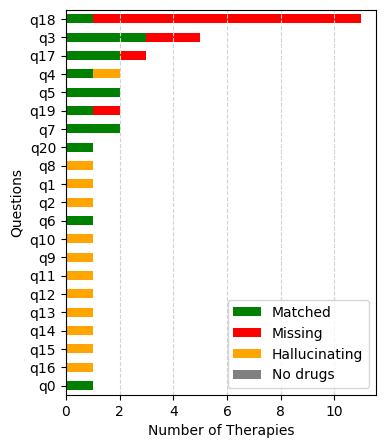

In [53]:
# Convert to DataFrame
df = pd.DataFrame(real_rag_res_cnt_df_4
[['Question_index','matching_cnt','missing_cnt','hallucinating_cnt','no_output_cnt']])

# Add a 'Total' column to sort by
df['total'] = df['matching_cnt'] + df['missing_cnt'] + df['hallucinating_cnt'] + df['no_output_cnt']

# Sort by the 'Total' column
df_sorted = df.sort_values('total', ascending=True)

# Stacked Bar Plot
fig, ax = plt.subplots(figsize=(4, 5))
df_sorted.set_index("Question_index")[['matching_cnt', 'missing_cnt', 'hallucinating_cnt', 'no_output_cnt']].plot(kind="barh", stacked=True, color=["green", "red", "orange", "grey"], ax=ax)

# Set axes background color
ax.set_facecolor('white') 

# Change background grid color
ax.grid(visible=True, axis='x', color='lightgray', linestyle='--')

# Labels
plt.xlabel("Number of Therapies")
plt.ylabel("Questions")
plt.xticks(rotation=0)
plt.legend(["Matched", "Missing", "Hallucinating","No drugs"], loc='lower right')

# Save
save = True
if save == True:
    plt.savefig('./figures/Figure4_realquestions_stackedbar_1.jpeg', dpi=500, bbox_inches='tight')
plt.show()


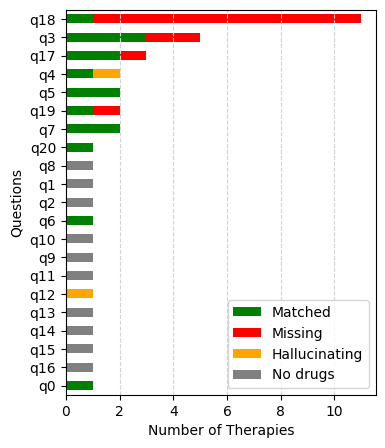

In [54]:
# Convert to DataFrame
df = pd.DataFrame(real_rag_res_cnt_df_5[['Question_index','matching_cnt','missing_cnt','hallucinating_cnt','no_output_cnt']])

# Add a 'Total' column to sort by
df['total'] = df['matching_cnt'] + df['missing_cnt'] + df['hallucinating_cnt'] + df['no_output_cnt']

# Sort by the 'Total' column
df_sorted = df.sort_values('total', ascending=True)

# Stacked Bar Plot
fig, ax = plt.subplots(figsize=(4, 5))
df_sorted.set_index("Question_index")[['matching_cnt', 'missing_cnt', 'hallucinating_cnt', 'no_output_cnt']].plot(kind="barh", stacked=True, color=["green", "red", "orange", "grey"], ax=ax)

# Set axes background color
ax.set_facecolor('white')

# Change background grid color
ax.grid(visible=True, axis='x', color='lightgray', linestyle='--')

# Labels
plt.xlabel("Number of Therapies")
plt.ylabel("Questions")
plt.xticks(rotation=0)
plt.legend(["Matched", "Missing", "Hallucinating","No drugs"], loc='lower right')

# Save
save = True
if save == True:
    plt.savefig('./figures/Figure4_realquestions_stackedbar_2.jpeg', dpi=500, bbox_inches='tight')
plt.show()


#### Figure 4C. Accuracies of RAG-LLM based on structured data on real-world questions

##### Plot bar graph

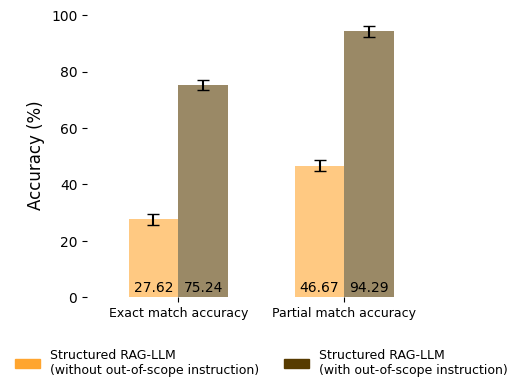

In [56]:
# compute means and standard deviations
means = {
    'Structured RAG-LLM \n(without out-of-scope instruction)': 
        [np.mean(all_real_results[4]['avg_exact']) * 100, np.mean(all_real_results[4]['avg_partial']) * 100],
    'Structured RAG-LLM \n(with out-of-scope instruction)': 
        [np.mean(all_real_results[5]['avg_exact']) * 100, np.mean(all_real_results[5]['avg_partial']) * 100]
}

stds = {
    'Structured RAG-LLM \n(without out-of-scope instruction)': 
        [np.std(all_real_results[4]['avg_exact']) * 100, np.std(all_real_results[4]['avg_partial']) * 100],
    'Structured RAG-LLM \n(with out-of-scope instruction)': 
        [np.std(all_real_results[5]['avg_exact']) * 100, np.std(all_real_results[5]['avg_partial']) * 100]
}

# convert to dataframe
plot_res = pd.DataFrame(means, index=['Exact match accuracy','Partial match accuracy'])

# Convert stds to DataFrame for error bars
error_bars = pd.DataFrame(stds, index=['Exact match accuracy','Partial match accuracy'])

# set figure size
plt.rcParams["figure.figsize"] = [4.5, 3.7]

# set color palette
cols=sns.color_palette(cc.glasbey, n_colors=40)

# create a mapping of rownames to colors
row_colors = dict(zip(plot_res.columns, [cols[7],cols[8]]))

# create bar plot
ax=plot_res.plot(kind='bar', 
                 yerr=error_bars,
                 capsize=4,
                 color=[row_colors[name] for name in plot_res.columns], 
                 width=0.6, 
                 legend=False
                 )

# add text
for bar in ax.patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax.text(x, 1, f'{y:.2f}', ha='center', va='bottom', fontsize=10, color='black')
    
# x, y labels, ticks, grid
ax.set_xlabel('')
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.tick_params(axis='x', labelsize=9, rotation=0)
ax.tick_params(axis='y', labelsize=10)
ax.set_facecolor(color='white')

# remove border
for spine in ax.spines.values():
    spine.set_visible(False)
    
# set alpha for the rest of the bars
for i, patch in enumerate(ax.patches):
    patch.set_alpha(0.6)

# Create a custom legend
handles = [plt.Rectangle((0,0),1,1, color=row_colors[name]) for name in plot_res.columns]
legend = ax.legend(handles, plot_res.columns, 
          title=False, 
          bbox_to_anchor=(0.5, -0.12), ncol=2,
          frameon=False,
          borderaxespad=1,
          loc='upper center',
          fontsize=9,
          title_fontsize=9
          ) 
legend.get_frame().set_facecolor('white')

# save
save = True
if save == True:
    plt.savefig('./figures/Figure4_realworld_accuracyRAGLLMbar.jpeg', dpi=500, bbox_inches='tight')
plt.show()

##### Run McNemar's Test

In [57]:
# Create contingency table
exact_table_ls=[]
partial_table_ls=[]

for i in range(5):
    exact_table_ls.append(create_mcnemar_table(
        all_real_results[4]['exact'][i], 
        all_real_results[5]['exact'][i]
        )
                          )
    
    partial_table_ls.append(create_mcnemar_table(
        all_real_results[4]['partial'][i], 
        all_real_results[5]['partial'][i]
        )
                            )

In [58]:
# Perform McNemar's test
exact_result_ls=[]
partial_result_ls=[]
exact_result_pval=[]
partial_result_pval=[]

for i in range(5):
    exact_result_ls.append(conduct_mcnemar_test(exact_table_ls[i]))
    partial_result_ls.append(conduct_mcnemar_test(partial_table_ls[i]))
    
    exact_result_pval.append(exact_result_ls[i].pvalue)
    partial_result_pval.append(partial_result_ls[i].pvalue)

# Perform multiple test correction
from statsmodels.stats.multitest import multipletests

rejected, exact_pval_corrected, _, _ = multipletests(exact_result_pval, alpha=0.05, method='fdr_bh')
rejected, partial_pval_corrected, _, _ = multipletests(partial_result_pval, alpha=0.05, method='fdr_bh')

print(exact_result_pval)
print(partial_result_pval)
print(exact_pval_corrected)
print(partial_pval_corrected)

[0.001953125, 0.00390625, 0.001953125, 0.0009765625, 0.001953125]
[0.001953125, 0.00390625, 0.001953125, 0.0009765625, 0.001953125]
[0.00244141 0.00390625 0.00244141 0.00244141 0.00244141]
[0.00244141 0.00390625 0.00244141 0.00244141 0.00244141]


##### Calculate mean precision, recall, F1 score

In [59]:
def compute_metric_mean(metric_name, results_dict, strategy, idx_list, n_runs: int=5) -> float:
    """Compute the mean of a metric over selected questions (e.g. with on-label FDA-approved drugs) across multiple runs"""
    means = []
    for x in range(n_runs):
        values = [
            val for i, val in enumerate(results_dict[strategy]['full'][x][metric_name])
            if i in idx_list
        ]
        means.append(np.mean(values))
    return np.mean(means)

fda_questions_idx = real_questions[real_questions['Is_there_an_approval'] == True].index

for metric in ['precision_ls','recall_ls','f1_ls']:
    avg = compute_metric_mean(
        metric_name=metric,
        results_dict=all_real_results,
        strategy=5,
        idx_list=fda_questions_idx
        )
    print(f"Avg {metric.replace('_ls','').capitalize()}: {avg*100:.4f}")

Avg Precision: 95.0000
Avg Recall: 78.5758
Avg F1: 80.5000


#### Supplementary Note 1-2. Example of synthetic prompt and output from RAG-LLM 

##### Unstructured version

In [60]:
# Input prompt
print(rag_unstruc_res_dict_0['input prompt'][0][180])


    Context information is below.
    ---------------------
    ['INDICATIONS AND USAGE  --------------------------  \nLynparza is a poly (ADP-ribose) polymerase (PARP) inhibitor indicated: \nOvarian cancer \n• for the maintenance treatment of adult patients with deleterious or \nsuspected deleterious germline or somatic BRCA-mutated advanced \nepithelial ovarian, fallopian tube or primary peritoneal cancer who are in \ncomplete or partial response to first-line platinum-based chemotherapy. \nSelect patients for therapy based on an FDA-approved companion \ndiagnostic for Lynparza. (1.1, 2.1) \n• in combination with bevacizumab for the maintenance treatment of adult \npatients with advanced epithelial ovarian, fallopian tube or primary \nperitoneal cancer who are in complete or partial response to first-line \nplatinum-based chemotherapy and whose cancer is associated with \nhomologous recombination deficiency (HRD)-positive status defined by \neither: \n• a deleterious or suspected de

In [61]:
# RAG-LLM response
print(rag_unstruc_res_dict_0['full output'][0][180])

{
  "Treatment 1": {
    "Disease Name": "Metastatic Castration-Resistant Prostate Cancer (mCRPC)",
    "Disease Phase or Condition": "Metastatic, Castration-Resistant",
    "Drug Name": "Lynparza",
    "Prior Treatment or Resistance Status": "Progressed following prior treatment with enzalutamide or abiraterone",
    "Genomic Features": "Somatic variant in gene BRCA1",
    "Link to FDA-approved Label": "https://www.accessdata.fda.gov/drugsatfda_docs/label/2020/213545s000lbl.pdf"
  },
  "Treatment 2": {
    "Disease Name": "Metastatic Castration-Resistant Prostate Cancer (mCRPC)",
    "Disease Phase or Condition": "Metastatic, Castration-Resistant",
    "Drug Name": "Rubraca",
    "Prior Treatment or Resistance Status": "Treated with androgen receptor-directed therapy and a taxane-based chemotherapy",
    "Genomic Features": "Somatic variant in gene BRCA1",
    "Link to FDA-approved Label": "https://www.accessdata.fda.gov/drugsatfda_docs/label/2018/211132s000lbl.pdf"
  },
  "Treatment 

##### Structured version

In [62]:
# Input prompt
print(rag_struc_res_dict_0['input prompt'][0][180])


    Context information is below.
    ---------------------
    ['If a prostate cancer patient has a somatic variant in gene BRCA1, and is metastatic castration resistant prostate cancer, one recommended treatment would be Olaparib. The U.S. Food and Drug Administration (FDA) granted approval to olaparib for adult patients with deleterious or suspected deleterous germline or somatic homologous recombination repair (HRR) gene-mutated metastatic castration-resistant prostate cancer (mCRPC), who have progressed following prior treatment with enzalutamide or abiraterone. (Citation: AstraZeneca Pharmaceuticals, LP. Lynparza (olaparib) [package insert]. U.S. Food and Drug Administration website. https://www.accessdata.fda.gov/drugsatfda_docs/label/2023/208558s025lbl.pdf. Revised May 2023. Accessed July 5, 2023.).', 'If a prostate cancer patient has a somatic variant in gene BRCA2, and is metastatic castration resistant prostate cancer, one recommended treatment would be Olaparib. The U.S. F

In [63]:
# RAG-LLM response 
print(rag_struc_res_dict_0['full output'][0][180])

{
  "Treatment 1": {
    "Disease Name": "Prostate Cancer",
    "Disease Phase or Condition": "Metastatic Castration-Resistant",
    "Drug Name": "Olaparib",
    "Prior Treatment or Resistance Status": "Progressed following prior treatment with enzalutamide or abiraterone",
    "Genomic Features": "Somatic variant in gene BRCA1",
    "Link to FDA-approved Label": "https://www.accessdata.fda.gov/drugsatfda_docs/label/2023/208558s025lbl.pdf"
  },
  "Treatment 2": {
    "Disease Name": "Prostate Cancer",
    "Disease Phase or Condition": "Metastatic Castration-Resistant",
    "Drug Name": "Abiraterone + Prednisone + Olaparib",
    "Prior Treatment or Resistance Status": "None specified",
    "Genomic Features": "Somatic variant in gene BRCA1",
    "Link to FDA-approved Label": "https://www.accessdata.fda.gov/drugsatfda_docs/label/2023/208558s025lbl.pdf"
  }
}


#### Supplementary Note 3. Example real-world query without FDA-approved drugs available

In [64]:
# An example of real-world expert query without FDA-approved drugs available
i=2
print(real_rag_res_dict_4['input prompt'][0][i])


    Context information is below.
    ---------------------
    ['If a inflammatory myofibroblastic tumor (imt) patient has a rearrangement in gene ALK, one recommended treatment would be Crizotinib. The U.S. Food and Drug Administration (FDA) granted approval to crizotinib for the treatment of adult and pediatric patients 1 year of age or older with unresectable, recurrent, or refactory inflammatory anaplastic lymphoma kinase (ALK)-positive myofibroblastic tumors (IMT). (Citation: Pfizer, Inc. Xalkori (crizotinib) [package insert]. U.S. Food and Drug Administration website. https://www.accessdata.fda.gov/drugsatfda_docs/label/2022/202570s033lbl.pdf. Revised July 2022. Accessed August 4th, 2022.).', 'If a anaplastic large cell lymphoma (alcl) patient has a rearrangement in gene ALK, one recommended treatment would be Crizotinib. The U.S. Food and Drug Administration (FDA) granted approval to crizotinib for the treatment of pediatric patients 1 year of age or older and young adults wit

In [65]:
# Full RAG-LLM's response from the corresponding real-world query
print(real_rag_res_dict_4['full output'][0][i])

{
  "Treatment 1": {
    "Disease Name": "Rhabdomyosarcoma",
    "Disease Phase or Condition": "Metastatic or unresectable",
    "Drug Name": "Crizotinib",
    "Prior Treatment or Resistance Status": "No prior treatment or resistant to prior treatment",
    "Genomic Features": "ALK (Anaplastic Lymphoma Kinase) fusion (TFCP2-ALK)",
    "FDA-approval status": "Not explicitly approved for rhabdomyosarcoma, but approved for ALK-positive solid tumors",
    "Link to FDA-approved Label": "https://www.accessdata.fda.gov/drugsatfda_docs/label/2022/202570s033lbl.pdf"
  }
}


Merge real-world results for supplementary table

In [ ]:
def create_selected_output_df(all_results_dict, selected_output, column_prefix):
    df = pd.DataFrame.from_dict(all_results_dict[selected_output]).T
    df = df.add_prefix(column_prefix)
    return(df)

strategy=5
input_df=create_selected_output_df(all_real_results[strategy], 'ragllm_input', 'RAGLLM_input_prompt_')
full_output_df=create_selected_output_df(all_real_results[strategy], 'ragllm_output', 'RAGLLM_full_output_')

pred_drug_output_ls = list()
for i in range(len(all_real_results[strategy]['full'])):
    pred_drug_output_ls.append(all_real_results[strategy]['full'][i]['pred_drugs_generic_set_ls'])

drug_output_df=pd.DataFrame(pred_drug_output_ls).T.add_prefix('RAGLLM_drug_output_')

In [157]:
real_supp_df = pd.concat([real_rag_res_cnt_df_5, drug_output_df, full_output_df, input_df], axis=1)
real_supp_df

# real_supp_df.to_csv("./real_supp_df.csv", index=False)

,Question_index,prompt,Asking_therapy,Given_biomarker,Question_category,Is_there_an_approval,Groundtruth_answers,Groundtruth_therapies,matching_cnt,missing_cnt,...,RAGLLM_full_output_0,RAGLLM_full_output_1,RAGLLM_full_output_2,RAGLLM_full_output_3,RAGLLM_full_output_4,RAGLLM_input_prompt_0,RAGLLM_input_prompt_1,RAGLLM_input_prompt_2,RAGLLM_input_prompt_3,RAGLLM_input_prompt_4
0,q0,What is the first-line treatment of metastatic...,True,True,"given disease and biomarker, return drugs",True,erdafitinib,[{'erdafitinib'}],1,0,...,"{\n ""Status"": ""success"",\n ""Treatment 1"": {\...","{\n ""Status"": ""success"",\n ""Treatment 1"": {\...","{\n ""Status"": ""success"",\n ""Treatment 1"": {\...","{\n ""Status"": ""success"",\n ""Treatment 1"": {\...","{\n ""Status"": ""success"",\n ""Treatment 1"": {\...",\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...
1,q1,Are PARP inhibitors used for patients with lei...,True,True,"given disease and biomarker, return drugs",False,PARP inhibitors are not yet approved for the t...,[],0,0,...,"{\n ""Status"": ""no_match"",\n ""Message"": ""No d...","{\n ""Status"": ""no_match"",\n ""Message"": ""No d...","{\n ""Status"": ""no_match"",\n ""Message"": ""No d...","{\n ""Status"": ""no_match"",\n ""Message"": ""No d...","{\n ""Status"": ""no_match"",\n ""Message"": ""No d...",\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...
2,q2,Are ALK inhibitors approved for use in TFCP2 f...,True,True,"given disease and biomarker, return drugs",False,"No, no ALK inhibitors are currently approved f...",[],0,0,...,"{\n ""Status"": ""no_match"",\n ""Message"": ""No d...","{\n ""Status"": ""no_match"",\n ""Message"": ""No d...","{\n ""Status"": ""no_match"",\n ""Message"": ""No d...","{\n ""Status"": ""no_match"",\n ""Message"": ""No d...","{\n ""Status"": ""no_match"",\n ""Message"": ""No d...",\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...
3,q3,For a patient with cancer metastatic prostate ...,True,True,"given disease and biomarker, return drugs",True,The following therapy and combination therapie...,"[{'olaparib'}, {'prednisone', 'olaparib', 'abi...",3,2,...,"{\n ""Status"": ""success"",\n ""Treatment 1"": {\...","{\n ""Status"": ""success"",\n ""Treatment 1"": {\...","{\n ""Status"": ""success"",\n ""Treatment 1"": {\...","{\n ""Status"": ""success"",\n ""Treatment 1"": {\...","{\n ""Status"": ""success"",\n ""Treatment 1"": {\...",\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...
4,q4,For a patient with HER2+ breast cancer after n...,True,True,"given disease and biomarker, return drugs; HER...",True,TDM-1 (ado-trastuzumab emtansine (Kadcyla)),[{'ado-trastuzumab emtansine'}],1,0,...,"{\n ""Status"": ""success"",\n ""Treatment 1"": {\...","{\n ""Status"": ""success"",\n ""Treatment 1"": {\...","{\n ""Status"": ""success"",\n ""Treatment 1"": {\...","{\n ""Status"": ""success"",\n ""Treatment 1"": {\...","{\n ""Status"": ""success"",\n ""Treatment 1"": {\...",\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...,\n Context information is below.\n -----...
5,q5,For patients with advanced cancer and with NTR...,True,True,"given disease and biomarker, return drugs",True,"Yes, the TRK inhibitors Entrectinib and Larotr...","[{'entre